In [6]:
library(gridtext)
library(ggplot2)
library(dplyr)
library(tibble)
library(ComplexHeatmap)
library(circlize)
library(wesanderson)
library(DOSE)
library(ggpubr)
library(rstatix)
library(ggprism)

## ESCs data

In [7]:
data.normalized <- read.csv('../Data/Metaboanalyst_4.12.21/data_normalized.csv')
data.normalized <- column_to_rownames(data.normalized, var = 'X')
data.normalized <- data.normalized[-c(1),]
data.normalized <- as.data.frame(sapply(data.normalized, as.numeric), row.names = rownames(data.normalized))

In [8]:
data.raw <- read.csv('../Data/Metaboanalyst_4.12.21/data_processed.csv')
data.raw <- column_to_rownames(data.raw, var = 'X')
data.raw <- data.raw[-c(1),]
data.raw <- as.data.frame(sapply(data.raw, as.numeric), row.names = rownames(data.raw))

In [9]:
tryptophan.data <- data.normalized[grep(pattern = 'try', rownames(data.normalized)),]

In [10]:
tryptophan.data <- as.data.frame(t(tryptophan.data))

In [11]:
tryptophan.data$Genotype <- c(rep('S6KO', 3), rep('WT', 3))

In [12]:
tryptophan.data$Genotype <- factor(tryptophan.data$Genotype, levels = rev(unique(tryptophan.data$Genotype)))

In [13]:
tryptophan.data

,tryptophan,Genotype
,<dbl>,<fct>
X071912QCCKO1,1.1426742,S6KO
X071912QCCKO2,1.0484558,S6KO
X071912QCCKO3,1.2608864,S6KO
X071912QCCTC1,0.5734160,WT
X071912QCCTC2,0.6054070,WT
X071912QCCTC3,0.5937748,WT


In [14]:
pval.esc <- tryptophan.data %>% 
    rstatix::pairwise_t_test(tryptophan ~ Genotype, p.adjust.method = "fdr") %>%
    rstatix::add_significance(p.col = "p.adj") %>%
    rstatix::add_xy_position(x = "Genotype")

## HeLa data

In [15]:
hela.data <- read.csv("../Data/hela.tryptophan.data.csv", row.names = 1)

In [16]:
hela.data$Genotype <- factor(hela.data$Genotype, levels = unique(hela.data$Genotype))

In [17]:
pval.hela <- hela.data %>% 
    rstatix::pairwise_t_test(`DL.Tryptophan..neg.` ~ Genotype, p.adjust.method = "fdr") %>%
    rstatix::add_significance(p.col = "p.adj") %>%
    rstatix::add_xy_position(x = "Genotype")

In [18]:
pval.hela$y.position <- 25.45

## SH-SY5Y

In [19]:
data.shsy <- read.csv('../Data/shsy5y.data.log2.csv', row.names = 1)

In [20]:
data.shsy <- as.data.frame(t(data.shsy['tryptophan_202_12.84', ]))

In [21]:
data.shsy$Genotype <- unlist(strsplit(rownames(data.shsy), split = '\\.'))[c(T,F)]

In [22]:
data.shsy$Genotype <- c('WT', 'WT', 'WT', 'WT', 'S6KO', 'S6KO', 'S6KO', 'S6KO')

In [23]:
data.shsy$Genotype <- factor(data.shsy$Genotype, levels = unique(data.shsy$Genotype))

In [24]:
pval.shsy <- data.shsy %>% 
        rstatix::pairwise_t_test(tryptophan_202_12.84 ~ Genotype, p.adjust.method = "fdr") %>%
        rstatix::add_significance(p.col = "p.adj") %>%
        rstatix::add_xy_position(x = "Genotype")

In [25]:
pval.shsy$y.position <- -0.01

In [26]:
data.shsy

,tryptophan_202_12.84,Genotype
,<dbl>,<fct>
WT.3,-0.7353040,WT
WT.4,-0.7381720,WT
WT.5,-0.5148534,WT
WT.6,-0.6864848,WT
KO.1,-0.2171450,S6KO
KO.2,-0.1639266,S6KO
KO.5,-0.4188785,S6KO
KO.6,-0.5903187,S6KO


In [32]:
p.esc <- ggplot(data=tryptophan.data, aes(x = Genotype, y = tryptophan)) +
    geom_jitter(aes(color = Genotype), 
                position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), 
                size = 5) +
    xlab(NULL) +
    scale_y_continuous(limits = c(0.5, 1.35), breaks = seq(0.5, 1.3, 0.2))+
    theme_dose(20) + ylab(bquote(~log[2]~(Abundance)))+
    ggtitle("mESC") +
    scale_color_manual(values = c("steelblue", "#8b0000")) +
    stat_summary(aes(group = Genotype), position = position_dodge(.5), 
                 geom = "errorbar", width = 0.145, size = 1.3, fun.min = min, fun.max = max) +
    stat_summary(aes(group=Genotype), position=position_dodge(.5), fun = mean, na.rm = TRUE, 
               geom = "point", color = "black", 
               size = 10, shape = "-") +
    add_pvalue(pval.esc, 
               tip.length = 0.01, 
               xmin = "xmin", 
               xmax = "xmax",
               label.size = 5, 
               bracket.size = 0.7) +

    theme(axis.text.x=element_text(color = "black", angle=45, vjust=.5))+
    theme(legend.position = 'none', plot.title = element_text(size=20))

In [33]:
p.hela <- ggplot(data=hela.data, aes(x = Genotype, y = `DL.Tryptophan..neg.`)) +
    geom_jitter(aes(color = Genotype), 
                position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), 
                size = 5)+
    xlab(NULL)+
    scale_y_continuous(limits = c(24.6, 25.462), breaks = seq(24.6, 25.4, 0.2))+
    theme_dose(20)+ylab(NULL)+
    ggtitle("HeLa")+
    scale_color_manual(values=c("steelblue", "#8b0000"))+
    stat_summary(aes(group=Genotype), position=position_dodge(.5), 
                 geom = "errorbar", width = 0.145, size = 1.3, fun.min = min, fun.max = max)+
    stat_summary(aes(group=Genotype), position=position_dodge(.5), fun = mean, na.rm = TRUE, 
               geom = "point", color = "black", 
               size = 10, shape = "-") +

    add_pvalue(pval.hela,  
               tip.length = 0.01, 
               xmin = "xmin", 
               xmax = "xmax",
               label.size = 5, 
               bracket.size = 0.7)+

    theme(axis.text.x=element_text(color = "black", angle=45, vjust=.5))+
    theme(legend.position = 'none', plot.title = element_text(size=20))

In [34]:
p.shsy <- ggplot(data=data.shsy, aes(x = Genotype, y = `tryptophan_202_12.84`)) +
    geom_jitter(aes(color = Genotype), 
                position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.5), 
                size = 5)+
    #ylim(-2,2)+
    xlab(NULL)+
    scale_y_continuous(limits = c(-0.8, 0), breaks = seq(-0.8, 0, 0.2))+
    theme_dose(20)+ylab(NULL)+
    ggtitle("SH-SY5Y")+
    scale_color_manual(values=c("steelblue", "#8b0000"))+
    stat_summary(aes(group=Genotype), position=position_dodge(.5), 
                 geom = "errorbar", width = 0.145, size = 1.3, fun.min = min, fun.max = max)+
    stat_summary(aes(group=Genotype), position=position_dodge(.5), fun = mean, na.rm = TRUE, 
               geom = "point", color = "black", 
               size = 10, shape = "-") +

    add_pvalue(pval.shsy,  
               tip.length = 0.01, 
               xmin = "xmin", 
               xmax = "xmax",
               label.size = 5, 
               bracket.size = 0.7)+

    theme(axis.text.x=element_text(color = "black", angle=45, vjust=.5))+
    theme(legend.position = 'none', plot.title = element_text(size=20))

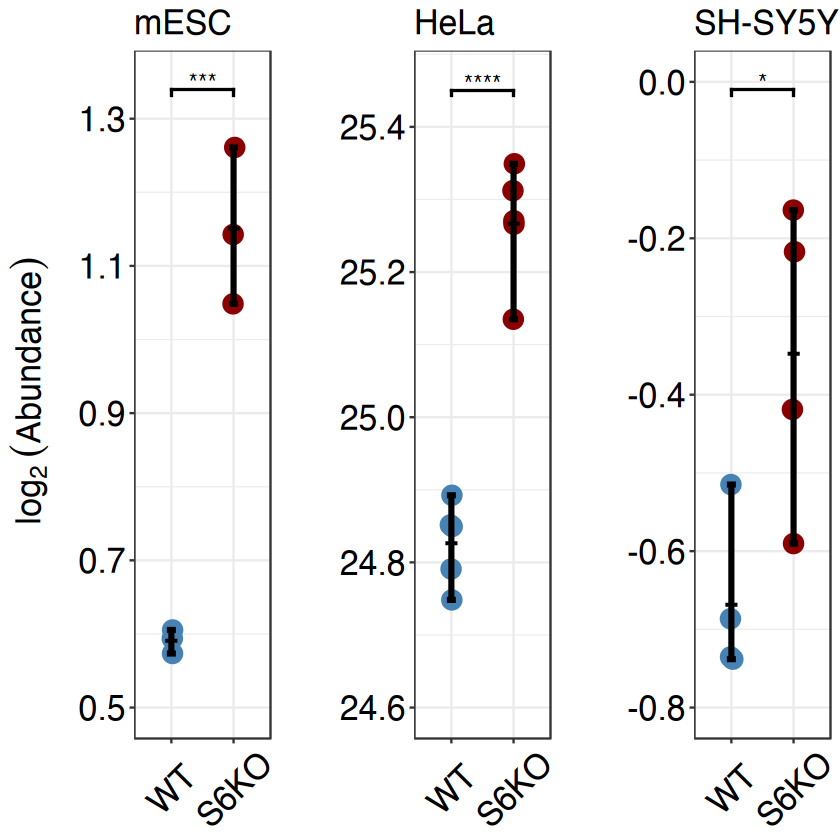

In [35]:
ggarrange(p.esc, p.hela, p.shsy, align = 'v',
          font.label = list(size = 22, face = "bold"),
          ncol = 3, nrow = 1)

In [36]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: aarch64-apple-darwin20
Running under: macOS Sonoma 14.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] ru_RU.UTF-8/ru_RU.UTF-8/ru_RU.UTF-8/C/ru_RU.UTF-8/ru_RU.UTF-8

time zone: Europe/Moscow
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggprism_1.0.5         rstatix_0.7.2         ggpubr_0.6.0         
 [4] DOSE_3.30.5           wesanderson_0.3.7     circlize_0.4.16      
 [7] ComplexHeatmap_2.20.0 tibble_3.3.0          dplyr_1.1.4          
[10] ggplot2_3.5.2         gridtext_0.1.5       

loaded via a namespace (and not attached):
 [1] DBI_1.2.3               httr2_1.0.3             rlang_1.1.6            
 [4] magrittr_2.0.3        